In [1]:
import torch
import torch.nn as nn
import egg.core as core

from torchvision import datasets, transforms
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, f1_score
import wandb

wandb.init(project="core", name="20250109")

# For convenince and reproducibility, we set some EGG-level command line arguments here
opts = core.init(params=['--random_seed=7', # will initialize numpy, torch, and python RNGs
                         '--lr=1e-4',   # sets the learning rate for the selected optimizer 
                         '--batch_size=32',
                         '--optimizer=adam'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(f"device: {device}")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yuc200312 (yuc200312-peiking-university). Use `wandb login --relogin` to force relogin


device: mps


In [2]:

# prepare data
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json
%matplotlib inline
%load_ext autoreload
%autoreload 2

datapath = 'data/guess_position.json'
# datapath = 'data/guess_position3x3.json'

map_ = (10, 10)
# map_ = (3, 3)
position1 = None
position2 = None
datasize = 10000
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
positionsize = 2
transform = transforms.ToTensor()

batch_size = opts.batch_size # set via the CL arguments above
result_path = 'results'
def cover(x, y, map, value=0.5):
    if x < 0 or x >= map_[0] or y < 0 or y >= map_[1]:
        return 
    if map[x, y] == 1:
        return 
    map[x, y] = value

def check(x, y, map, visited, value=0.5):
    if x < 0 or x >= map_[0] or y < 0 or y >= map_[1]:
        return 0
    if visited[x, y] == 1:
        return 0
    visited[x, y] = 1
    if map[x, y] >= 1-1e-6:
        return check(x + 1, y, map, visited, value) + check(x - 1, y, map, visited, value) + check(x, y + 1, map, visited, value) + check(x, y - 1, map, visited, value)
    if map[x, y] == value:
        return 0
    return 1

def generate_data_epoch(value = 0.5, position_num = 2):
    positions = []
    ground_truth_position = []
    
    x = np.random.choice(range(map_[0]), position_num, replace=False)
    y = np.random.choice(range(map_[1]), position_num)
    for i in range(position_num):
        positions.append((x[i], y[i]))
        ground_truth_position.append((float(x[i]), float(y[i])))
    map = np.zeros(map_)
    # fill the map
    for i in range(map_[0]):
        for j in range(map_[1]):
            value_ = np.random.rand() - 0.5
            if value_ > 0:
                map[i, j] = value_ * 0.1
            else:
                map[i, j] = 0
    ground_truth = np.zeros(map_)
    
    for i in positions:
        map[i] = 1
        ground_truth[i] = 1
    random = np.random.rand()
    pobability = [i/(position_num+1) for i in range(1,position_num+2)]
    pobability = np.array(pobability)
    index = pobability > random
    num_mask = position_num + 1 - np.sum(index)
    for idx in range(num_mask):
        for i in range(-1, 2):
            for j in range(-1, 2):
                cover(positions[idx][0] + i, positions[idx][1] + j, map, value)
    
    for i in positions:
        visited = np.zeros(map_)
        count = 0
        count = check(i[0], i[1], map, visited, value)
        if count == 0:
            ground_truth[i] = 0
    
    return map, ground_truth, ground_truth_position

def get_data(save_path, datasize = 10000, value = 0.5, position_num = 2):
    save_path = save_path.replace('.json', f'_{datasize}.json')
    if os.path.exists(save_path):
        print(f"load data from {save_path}")
        with open(save_path, 'r') as f:
            data = json.load(f)
        train_, test_ = train_test_split(data, test_size=0.2)
        return train_, test_
    data = []
    
    for i in tqdm(range(datasize)):
        map, ground_truth, ground_truth_position = generate_data_epoch(value, position_num)
        data.append({
            'id': i,
            'map': map.tolist(),
            'ground_truth': ground_truth.tolist(),
            'ground_truth_position': ground_truth_position
        })
    with open(save_path, 'w') as f:
        json.dump(data, f)
    print(f"save and load data from {save_path}")
    with open(save_path, 'r') as f:
        data = json.load(f)
    train_, test_ = train_test_split(data, test_size=0.2)
    return train_, test_


    



In [3]:
train_data, test_data = get_data(datapath, datasize, 0.5, positionsize)
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        map = torch.tensor(self.data[idx]['map']).float()
        ground_truth = torch.tensor(self.data[idx]['ground_truth']).float()
        ground_truth_position = torch.tensor(self.data[idx]['ground_truth_position']).int()
        
        # print(ground_truth_position)    
        # return map.view(1, 10, 10), ground_truth.view(1, 10, 10), ground_truth_position
        return map.view(1, map_[0], map_[1]), ground_truth.view(1, map_[0], map_[1]), ground_truth_position
train_loader = torch.utils.data.DataLoader(Dataset(train_data), batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(Dataset(test_data), batch_size=batch_size, shuffle=False, **kwargs)

load data from data/guess_position_10000.json


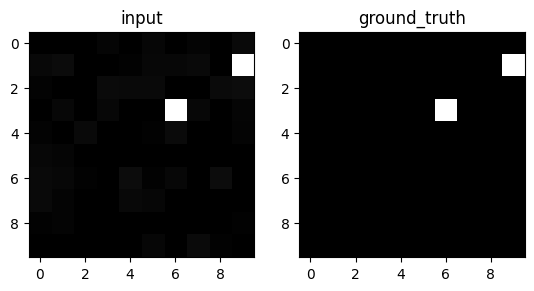

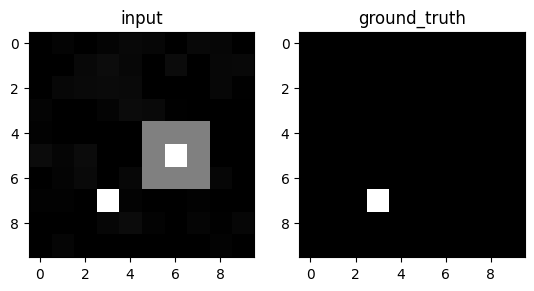

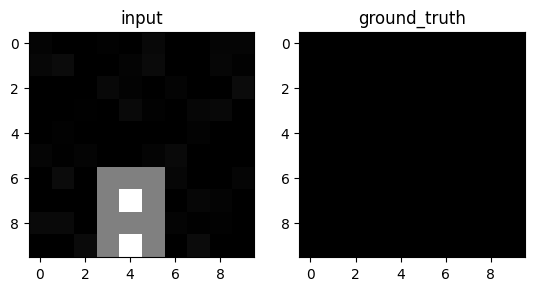

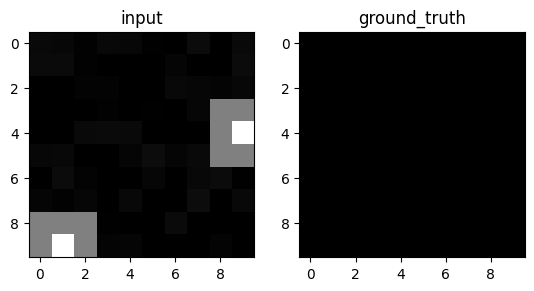

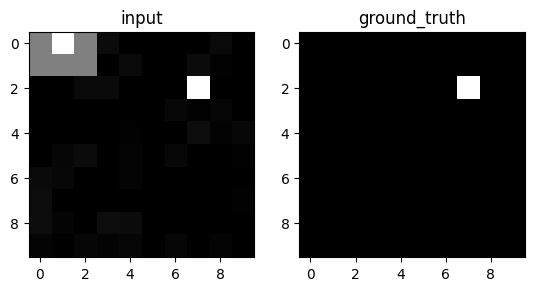

In [4]:
# visualize data
def visualize_data(inputlist: list, savepath = None, num = 0):
    number = len(inputlist)
    input = np.array(inputlist[0])
    # print(input)
    ground_truth_ = np.array(inputlist[1])
    if number > 2:
        predict_ = np.array(inputlist[2])
    if number > 3:
        message_ = np.array(inputlist[3])
    plt.subplot(1, number, 1)
    plt.imshow(input, cmap='gray', vmin=0, vmax=1)
    plt.title('input')
    plt.subplot(1, number, 2)
    plt.imshow(ground_truth_, cmap='gray' , vmin=0, vmax=1)
    plt.title('ground_truth') 
    if number > 2:
        plt.subplot(1, number, 3)
        plt.imshow(predict_, cmap='gray', vmin=0, vmax=1)
        plt.title('predict')
    if number > 3:
        plt.subplot(1, number, 4)
        plt.imshow(message_, cmap='gray', vmin=0, vmax=1)
        plt.title('message')
    if savepath is not None:
        plt.savefig(os.path.join(savepath, 'visualize_' + str(num) + '.png'))
    plt.show()
    plt.close()
    

visualize_data_ = np.random.choice(train_data, 5)
for data in visualize_data_:
    # print(data['map'])
    visualize_data([data['map'], data['ground_truth']])
    
    

In [5]:
class Vision(nn.Module):
    def __init__(self):
        super(Vision, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 1, 1)
        self.conv2 = nn.Conv2d(20, 50, 3, 1, 1)
        self.conv4 = nn.Conv2d(1, 50, 1, 1)
        self.conv5 = nn.Conv2d(1, 50, 3, 1, 1)
        self.fc = nn.Linear(10*10*(50+50+50+1), 10*10*20)
        self.batchnorm = nn.BatchNorm1d(10*10*20)
        
    def forward(self, x):
        x_1 = F.leaky_relu(self.conv1(x))
        x_2 = F.leaky_relu(self.conv2(x_1))
        x_3 = F.leaky_relu(self.conv5(x))
        x_4 = F.leaky_relu(self.conv4(x))
        x = torch.cat([x_2, x_3, x_4, x], dim=1)
        x = x.view(-1, 10*10*(50+50+50+1))
        x = self.fc(F.leaky_relu(x))
        x = self.batchnorm(x)
        
        return x

class PretrainNet(nn.Module):
    def __init__(self, vision_module):
        super(PretrainNet, self).__init__()
        self.vision_module = vision_module
        self.fc = nn.Linear(10*10*20, 100)
        
    def forward(self, x):
        x = self.vision_module(x)
        x = self.fc(F.leaky_relu(x))
        x = F.sigmoid(x)
        return x

In [6]:
vision = Vision()
class_prediction = PretrainNet(vision) #  note that we pass vision - which we want to pretrain
optimizer = core.build_optimizer(class_prediction.parameters()) #  uses command-line parameters we passed to core.init
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
class_prediction = class_prediction.to(device)

In [7]:
from tqdm import tqdm
pbar = tqdm(range(50), desc="Training loss")
model_path = './model'
if not os.path.exists(model_path):
    os.makedirs(model_path)
if os.path.exists(os.path.join(model_path, 'pretrain.pth')):
    class_prediction.load_state_dict(torch.load(os.path.join(model_path, 'pretrain.pth'))["model"])
if os.path.exists(os.path.join(model_path, 'vision.pth')):
    vision.load_state_dict(torch.load(os.path.join(model_path, 'vision.pth'))["model"])
if not os.path.exists(os.path.join(model_path, 'pretrain.pth')):

    for epoch in pbar:
        mean_loss, n_batches = 0, 0
        accuracy = []
        for batch_idx, (data, target, position_) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = class_prediction(data)
            target = target.view(-1, map_[0]*map_[1])
            loss_avaliable = 0
            loss_unavaliable = 0
            number_positions = position_.shape[1]
            accuracy_ = 0
            for i in range(number_positions):
                position = position_[:, i]
                masked = [target[j, position[j][0]*map_[1] + position[j][1]] for j in range(len(target))]

                masked = torch.stack(masked)
                masked_avalible = masked == 1.0
                masked_unavalible = masked == 0.0
                output_ = [output[j, position[j][0]*map_[1] + position[j][1]] for j in range(len(output))]
                output_ = torch.stack(output_)
                loss_avaliable += (1.0 - output_[masked_avalible]).mean()
                loss_unavaliable += output_[masked_unavalible].mean()
                # normalize to 0-1
                output_ = (output_ - output_.min())/(output_.max() - output_.min())
                
                avaliable = (output_[masked_avalible] >= (1 - 1e-4)).sum().item()
                unavaliable = (output_[masked_unavalible] <= 1e-4).sum().item()
                accuracy_ += (avaliable + unavaliable) / (positionsize * len(output))
            accuracy.append(accuracy_)
            
            loss = F.binary_cross_entropy(output, target, reduction='none').mean() + 0.5 * loss_avaliable + 0.5 * loss_unavaliable
            # loss = F.binary_cross_entropy(output, target, reduction='none').mean() + loss_avaliable
            
            loss.backward()
            optimizer.step()
            
            mean_loss += loss.mean().item()
            n_batches += 1
        
        mean_loss /= n_batches
        accuracy = sum(accuracy) / n_batches
        pbar.set_description(f"Training loss: {mean_loss:.10f}, Accuracy: {accuracy:.10f}")
        # wandb.log({'pretrain/loss': mean_loss}, step=epoch)
        # wandb.log({'pretrain/accuracy': accuracy}, step=epoch)
        wandb.log({'pretrain/loss': mean_loss, 'pretrain/accuracy': accuracy})
        scheduler.step()

pbar.close()
    

Training loss: 0.0020786844, Accuracy: 0.5167500000: 100%|██████████| 50/50 [07:46<00:00,  9.34s/it]


In [8]:
# save model
if not os.path.exists(os.path.join(model_path, 'pretrain.pth')):
    torch.save({'model': class_prediction.state_dict()}, os.path.join(model_path, 'pretrain.pth'))
if not os.path.exists(os.path.join(model_path, 'vision.pth')):
    torch.save({'model': vision.state_dict()}, os.path.join(model_path, 'vision.pth'))

Test loss: 0.0233812844 Accuracy: 0.5248015873


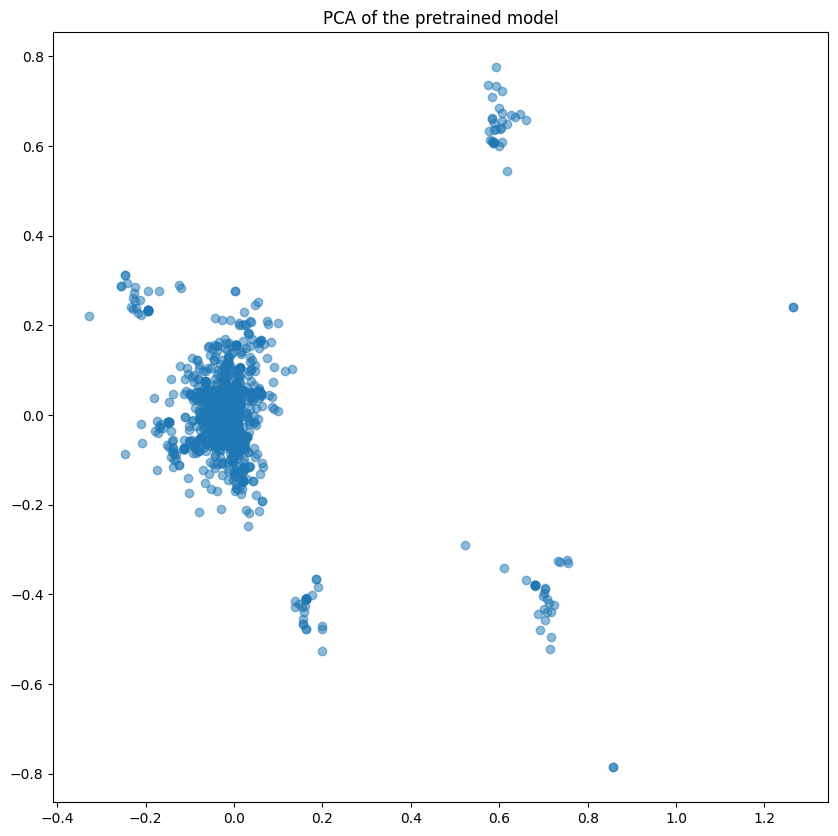

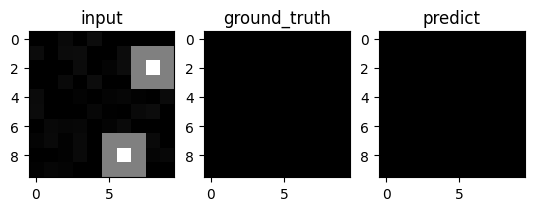

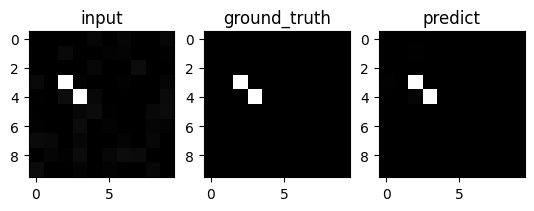

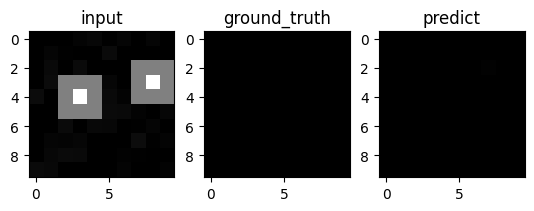

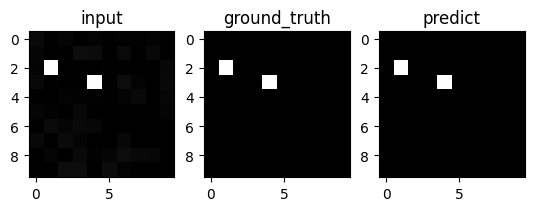

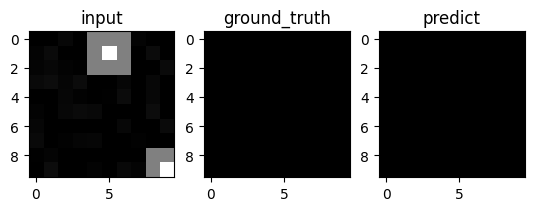

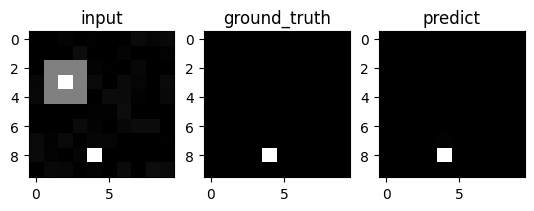

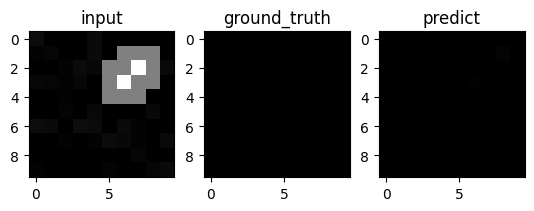

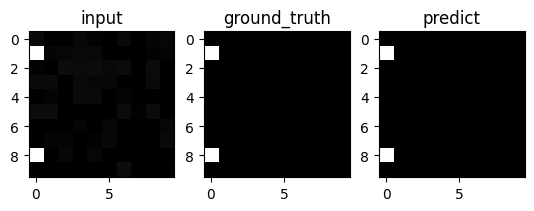

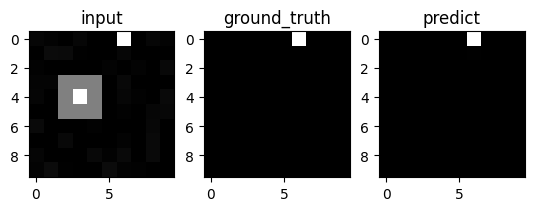

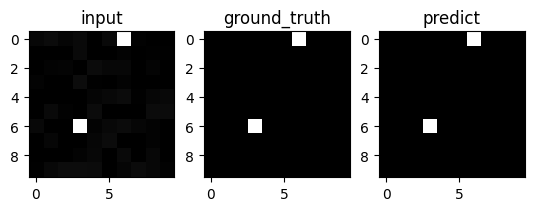

In [9]:
# Evaluate the pretraining
savefile = 'pretrain'
if not os.path.exists(os.path.join(result_path, savefile)):
    os.makedirs(os.path.join(result_path, savefile))
class_prediction.eval()
mean_loss, n_batches = 0, 0
outputs = []
accuracy = []
for batch_idx, (data, target,position_) in enumerate(test_loader):
    # print(batch_idx)
    data, target = data.to(device), target.to(device)
    output = class_prediction(data)
    outputs.append(output)
    loss_avaliable = 0
    loss_unavaliable = 0
    number_positions = position_.shape[1]
    target = target.view(-1, map_[0]*map_[1])
    accuracy_ = 0
    for i in range(number_positions):
        position = position_[:, i]
        masked = [target[j, position[j][0]*map_[1] + position[j][1]] for j in range(len(position))]
        masked = torch.stack(masked)
        masked_avalible = masked == 1.0
        masked_unavalible = masked == 0.0
        output_ = [output[j, position[j][0]*map_[1] + position[j][1]] for j in range(len(position))]
        output_ = torch.stack(output_)
        
        loss_avaliable += (1.0 - output_[masked_avalible]).mean()
        loss_unavaliable += output_[masked_unavalible].mean()
        output_ = (output_ - output_.min())/(output_.max() - output_.min())
        
        avaliable = (output_[masked_avalible] >= (1 - 1e-4)).sum().item()
        unavaliable = (output_[masked_unavalible] <= 1e-4).sum().item()
        accuracy_ += (avaliable + unavaliable) / (positionsize * len(output))
        
    
    loss = F.binary_cross_entropy(output, target, reduction='none').mean() + loss_avaliable + loss_unavaliable

    mean_loss += loss.mean().item()
    n_batches += 1
    accuracy.append(accuracy_)
mean_loss /= n_batches
accuracy = sum(accuracy) / n_batches
print(f"Test loss: {mean_loss:.10f}", f"Accuracy: {accuracy:.10f}")
outputs = torch.cat(outputs, dim=0)
pca = PCA(n_components=2)
outputs_pca = pca.fit_transform(outputs.cpu().detach().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(outputs_pca[:, 0], outputs_pca[:, 1], alpha=0.5)
plt.title("PCA of the pretrained model")
plt.savefig(os.path.join(result_path, savefile, 'pca_pretrain.png'))
plt.show()
plt.close()
# visualize the prediction
class_prediction.eval()
data, target,_ = next(iter(test_loader))
data, target = data.to(device), target.to(device)
output = class_prediction(data)
# output = torch.sigmoid(output)
output = output.view(-1, map_[0], map_[1])
target = target.view(-1, map_[0], map_[1])
for i in range(10):
    visualize_data([data[i].cpu().detach().numpy().squeeze(), target[i].cpu().detach().numpy().squeeze(), output[i].cpu().detach().numpy().squeeze()], os.path.join(result_path, savefile), i)


In [10]:
class Sender(nn.Module):
    def __init__(self, vision, output_size):
        super(Sender, self).__init__()
        self.vision = vision
        self.fc = nn.Linear(2000, output_size)
        
    def forward(self, x, aux_input=None):
        with torch.no_grad():
            x = self.vision(x)
        x = self.fc(F.leaky_relu(x))
        
        return x
    
    
class Receiver(nn.Module):
    def __init__(self, input_size):
        super(Receiver, self).__init__()
        self.fc = nn.Linear(input_size, 250)
        self.fc2 = nn.Linear(250, 100)

    def forward(self, channel_input, receiver_input=None, aux_input=None):
        x = self.fc(channel_input)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x

sender = Sender(vision, output_size=1000)
receiver = Receiver(input_size=1000)

In [11]:

def loss(sender_input, _message, _receiver_input, receiver_output, _labels, _aux_input=None):
    if _receiver_input is not None:
        
        loss_avaliable = 0
        loss_unavaliable = 0
        number_positions = _receiver_input.shape[1]
        # print(_receiver_input.shape)
        accuracy = 0
        _labels = _labels.view(-1, _labels.shape[-1]*_labels.shape[-2])
        
        for i in range(number_positions):
            position = _receiver_input[:, i]
            masked = [ _labels[j, position[j][0]*map_[1] + position[j][1]] for j in range(len(_labels))]
            masked = torch.stack(masked)
            masked_avalible = masked == 1.0
            masked_unavalible = masked == 0.0
            output_ = [receiver_output[j, position[j][0]*map_[1] + position[j][1]] for j in range(len(_labels))]
            output_ = torch.stack(output_)
            loss_avaliable += (1.0 - output_[masked_avalible]).mean()
            loss_unavaliable += (output_[masked_unavalible]).mean()
            output_ = (output_ - output_.min())/(output_.max() - output_.min())
            
            avaliable = (output_[masked_avalible] >= (1 - 1e-4)).sum().item()
            unavaliable = (output_[masked_unavalible] <= 1e-4).sum().item()
            accuracy += (avaliable + unavaliable) / (positionsize * len(_labels))
            
        loss = F.binary_cross_entropy(receiver_output, _labels, reduction='none').mean()+ loss_avaliable +  loss_unavaliable
    return [loss, accuracy], {}

In [12]:
vocab_size = 100

In [13]:
sender = Sender(vision, vocab_size)
sender = core.GumbelSoftmaxWrapper(sender, temperature=1.0) # wrapping into a GS interface, requires GS temperature
receiver = Receiver(input_size=400)
receiver = core.SymbolReceiverWrapper(receiver, vocab_size, agent_input_size=400)


In [14]:
game = core.SymbolGameGS(sender, receiver, loss)
optimizer = torch.optim.Adam(game.parameters())
optimizer_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
trainer = core.Trainer(
    game=game, optimizer=optimizer, train_data=train_loader, optimizer_scheduler=optimizer_scheduler, 
    validation_data=test_loader, callbacks=[core.TemperatureUpdater(agent=sender, decay=0.9, minimum=0.1)],device=device    
)

In [15]:

n_epochs = 50
wandb.finish()
wandb.init(project="core", name="20250109_"+game.__class__.__name__)

trainer.train(n_epochs)

pretrain/accuracy,▁▁▂▂▃▄▄▅▅▆▆▆▇▇▇▇▇▇██████████████████████
pretrain/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
pretrain/accuracy,0.51675
pretrain/loss,0.00208


Epoch 50/50: train_loss=0.8209170103, train_accuracy=0.3513750000: 100%|██████████| 50/50 [12:33<00:00, 15.06s/it]


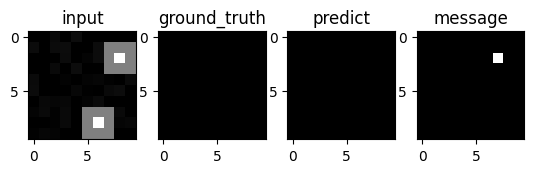

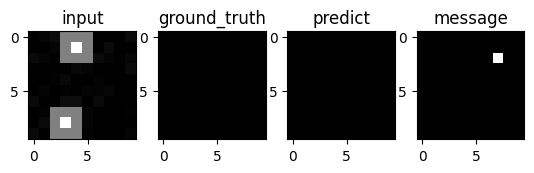

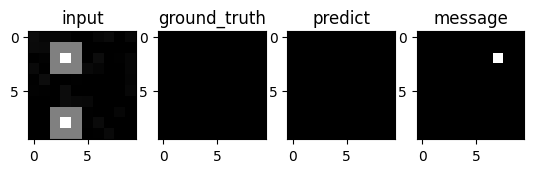

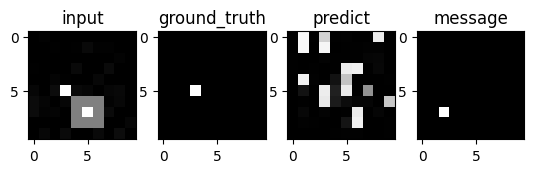

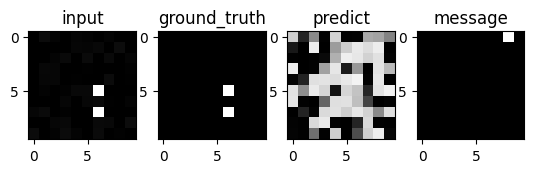

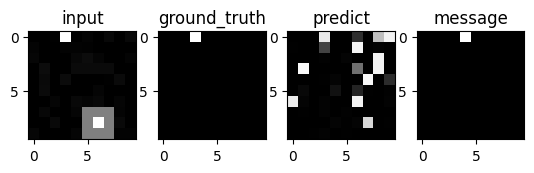

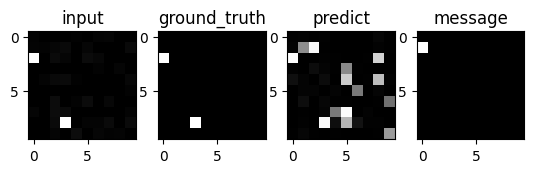

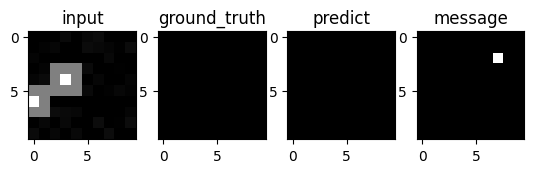

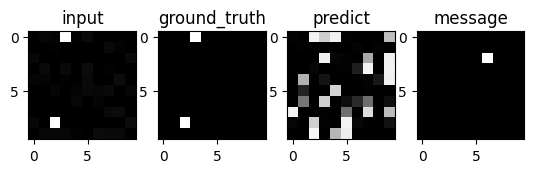

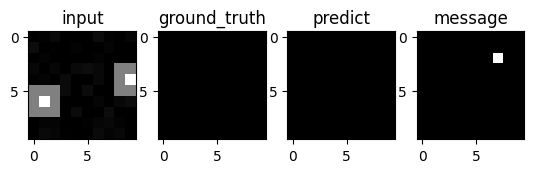

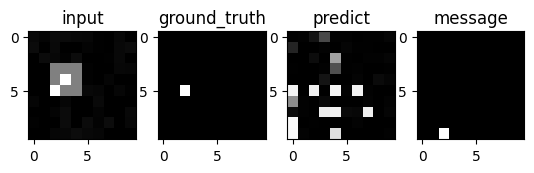

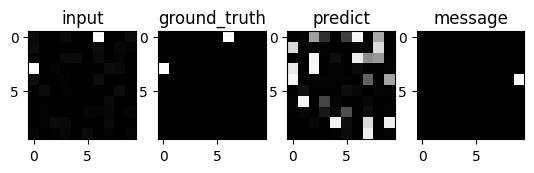

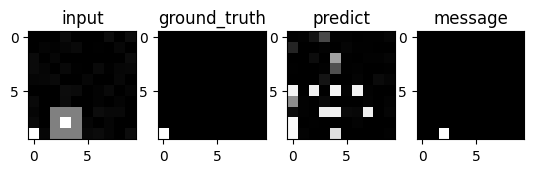

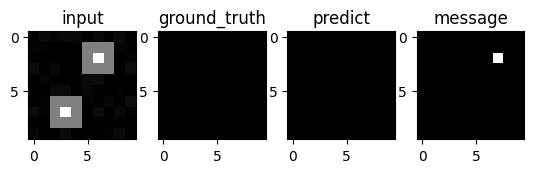

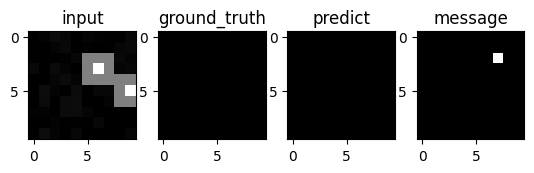

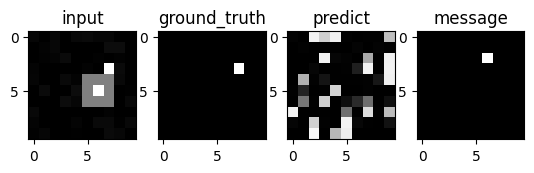

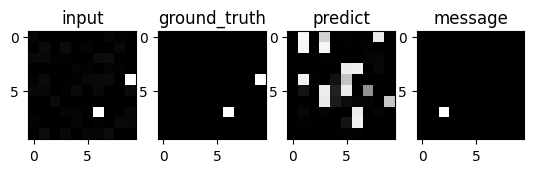

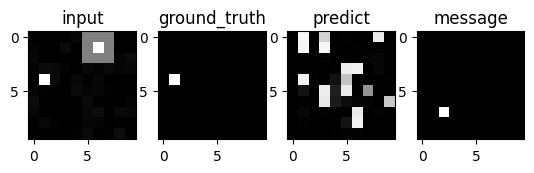

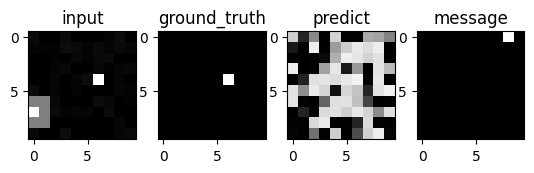

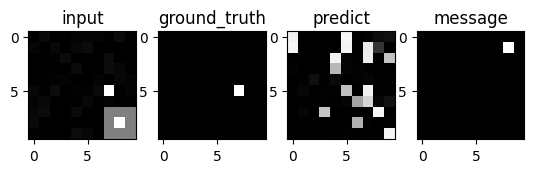

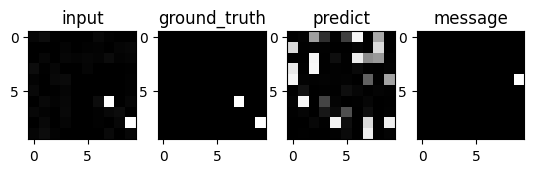

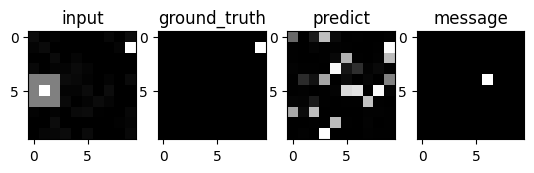

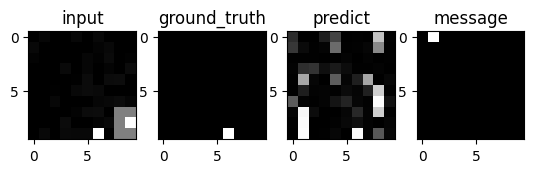

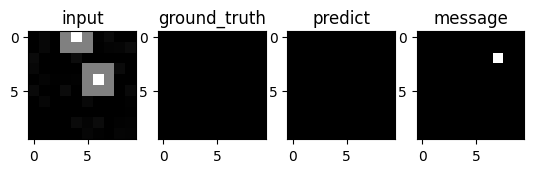

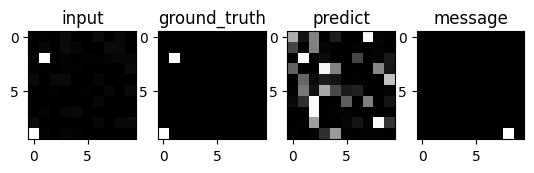

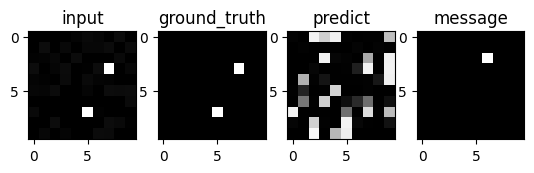

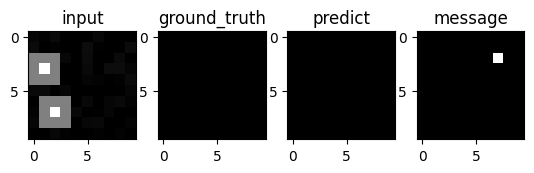

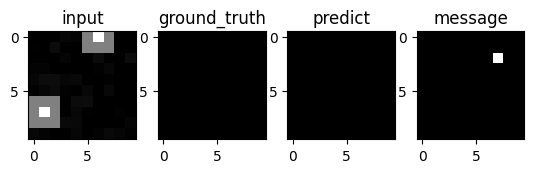

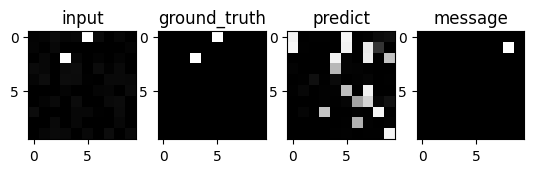

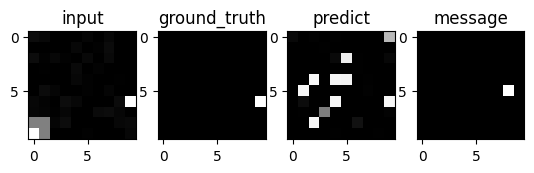

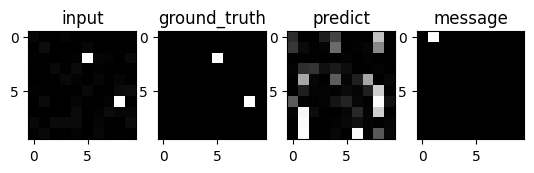

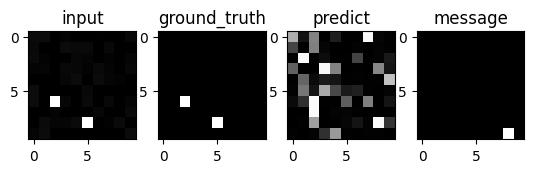

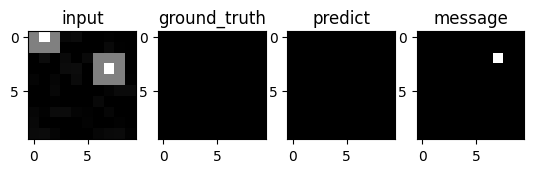

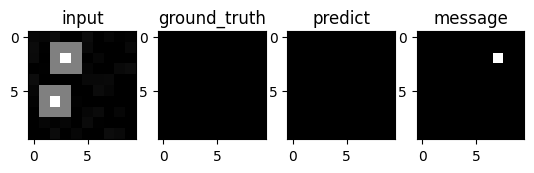

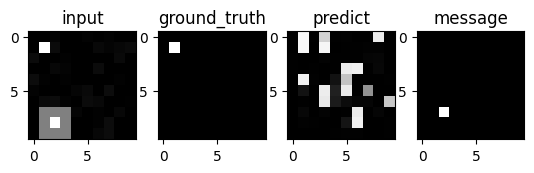

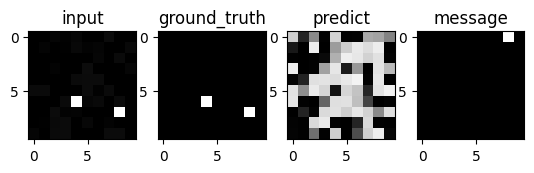

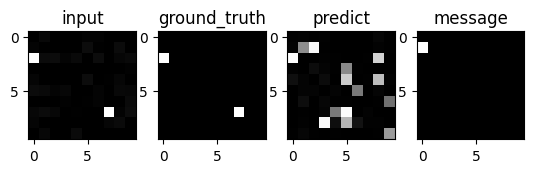

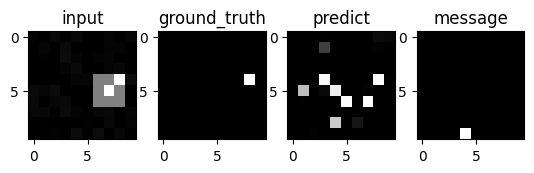

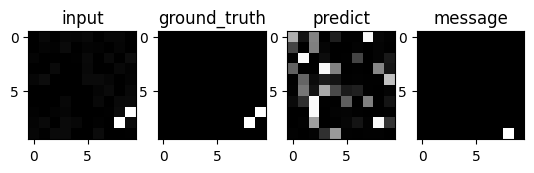

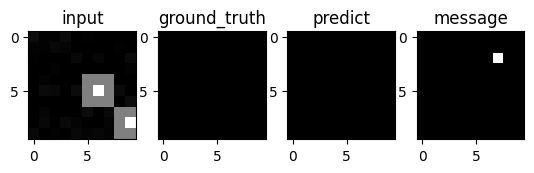

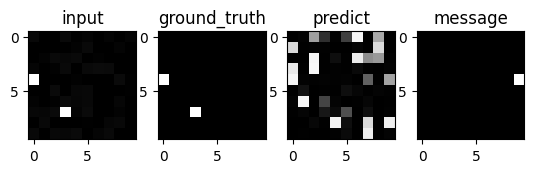

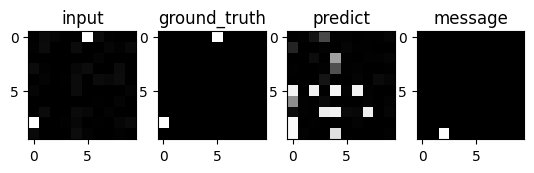

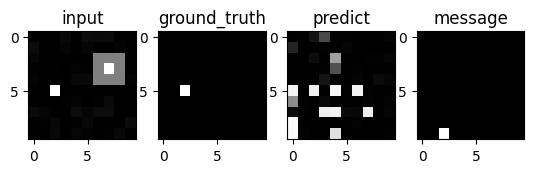

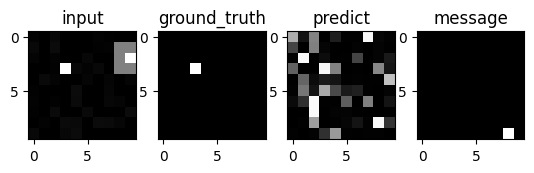

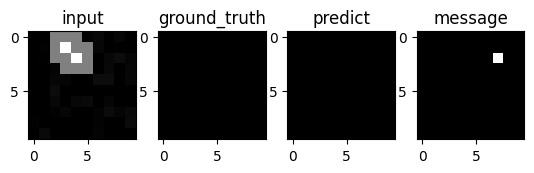

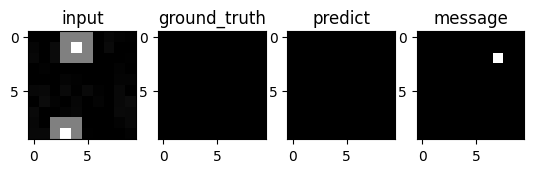

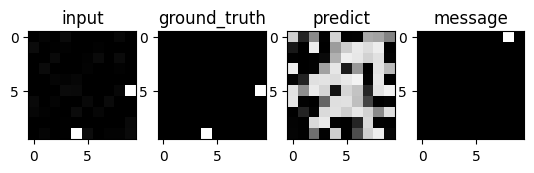

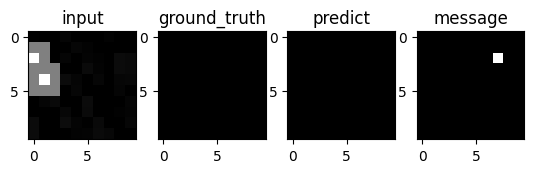

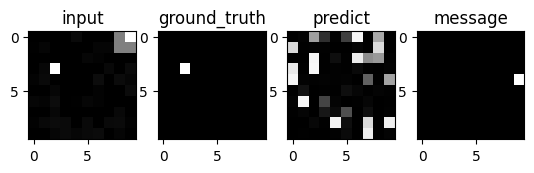

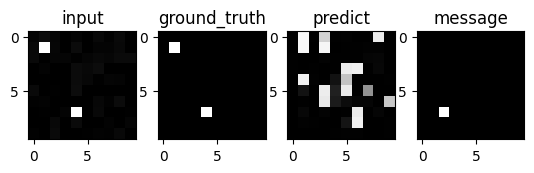

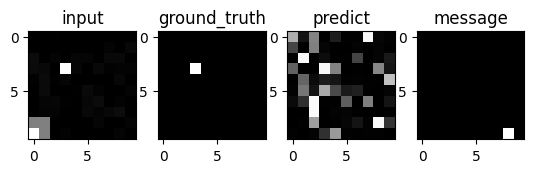

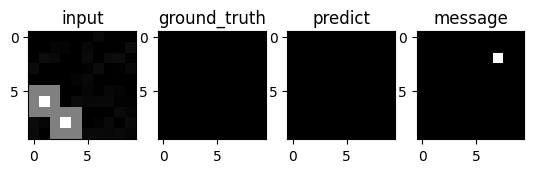

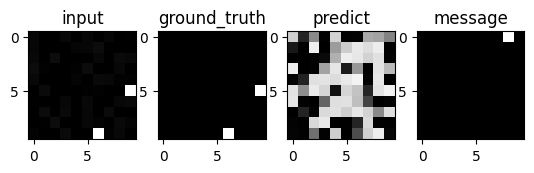

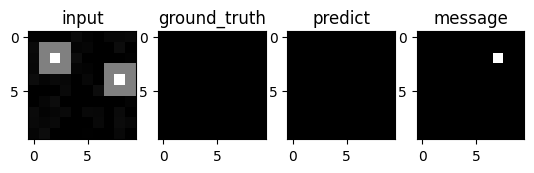

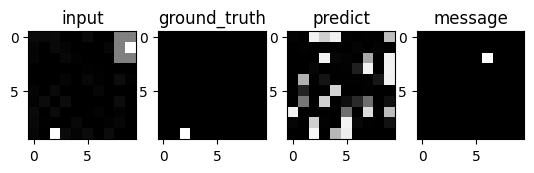

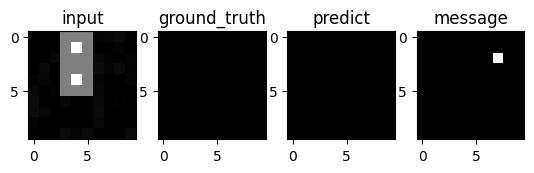

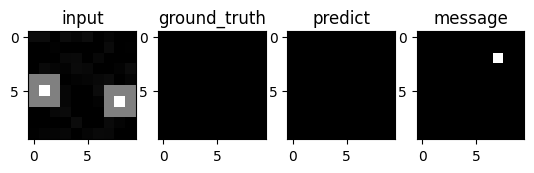

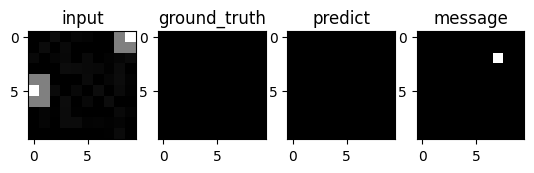

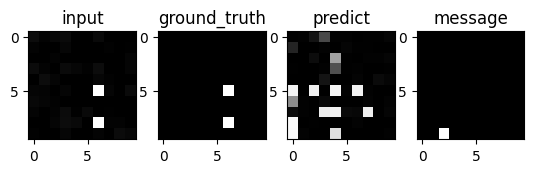

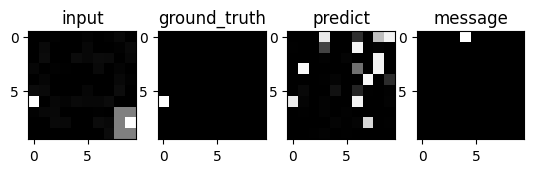

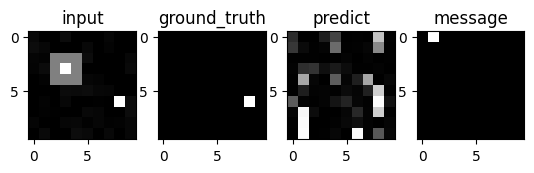

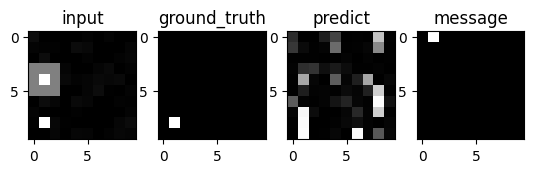

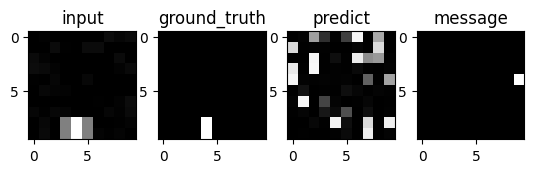

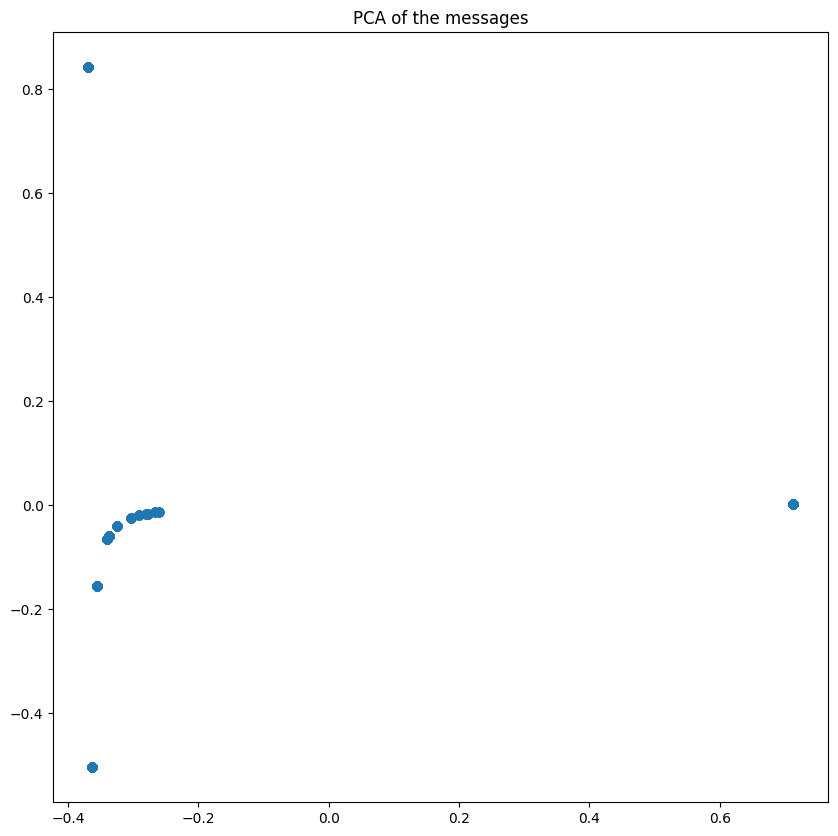

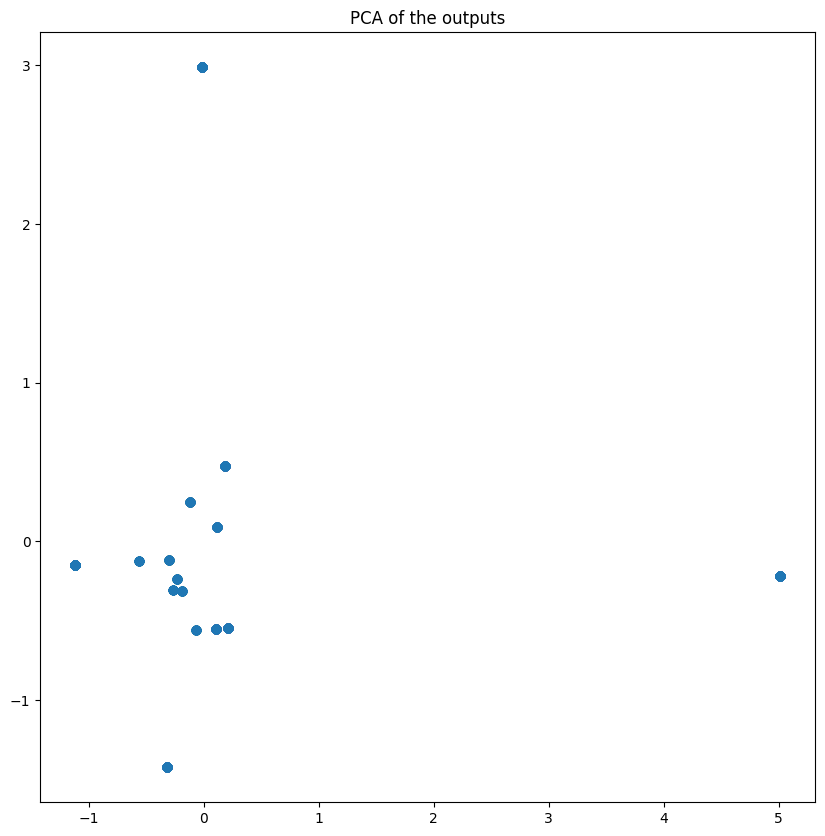

In [20]:
savefile = game.__class__.__name__
if not os.path.exists(os.path.join(result_path, savefile)):
    os.makedirs(os.path.join(result_path, savefile))
game = game.to(device)
game.eval()

messages = []
outputs = []

for batch_idx, z in enumerate(test_loader):
    data, target, _ = z
    data, target = data.to(device), target.to(device)
    with torch.no_grad():
        message = game.sender(data)
        output = game.receiver(message)
        messages.append(message)
        outputs.append(output)
    output = output.view(-1, 10, 10)
    target = target.view(-1, 10, 10)
    message = message.view(-1, 10, 10)
    visualize_data([data[0].cpu().detach().numpy().squeeze(), target[0].cpu().detach().numpy().squeeze(), output[0].cpu().detach().numpy().squeeze(), message[0].cpu().detach().numpy().squeeze()], os.path.join(result_path, savefile), batch_idx)
messages = torch.cat(messages, dim=0)
outputs = torch.cat(outputs, dim=0)
pca = PCA(n_components=2)
messages_pca = pca.fit_transform(messages.cpu().detach().numpy())
outputs_pca = pca.fit_transform(outputs.cpu().detach().numpy())
plt.figure(figsize=(10, 10))
plt.scatter(messages_pca[:, 0], messages_pca[:, 1], alpha=0.5)
plt.title("PCA of the messages")
plt.savefig(os.path.join(result_path, savefile, game.__class__.__name__ + "_messages.png"))
plt.show()
plt.close()
plt.figure(figsize=(10, 10))
plt.scatter(outputs_pca[:, 0], outputs_pca[:, 1], alpha=0.5)
plt.title("PCA of the outputs")
plt.savefig(os.path.join(result_path, savefile, game.__class__.__name__ + "_outputs.png"))
plt.show()
plt.close()

